# Step 3: DPA on Firmware Implementation of AES

**SUMMARY:** *In the previous step, you saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.*

*Next, we'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.*

*This is all based on the assumption we discussed in the slides and saw in earlier labs: there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.*

**LEARNING OUTCOMES:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.


In [27]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET = 'TINYAES128C'
SS_VER = 'SS_VER_2_1'

In [28]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍


In [29]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (15:13.2.rel1-2) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f0/stm32f0_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-C

/usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/bin/ld: /usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/lib/thumb/v6-m/nofp/libg_nano.a(libc_a-closer.o): in function `_close_r':
/build/newlib-38V0JC/newlib-4.4.0.20231231/build_nano/arm-none-eabi/thumb/v6-m/nofp/newlib/../../../../../../newlib/libc/reent/closer.c:47:(.text+0xc): warning: _close is not implemented and will always fail
/usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/bin/ld: /usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/lib/thumb/v6-m/nofp/libg_nano.a(libc_a-fstatr.o): in function `_fstat_r':
/build/newlib-38V0JC/newlib-4.4.0.20231231/build_nano/arm-none-eabi/thumb/v6-m/nofp/newlib/../../../../../../newlib/libc/reent/fstatr.c:55:(.text+0xe): warning: _fstat is not implemented and will always fail
/usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/bin/ld: /usr/lib/gcc/arm-none-eabi/13.2.1/../../../arm-none-eabi/lib/thumb/v6-m/nofp/libg_nano.a(libc_a-signalr.o): in function `_getpi

.
Creating load file for EEPROM: simpleserial-aes-CWNANO.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
--change-section-lma .eeprom=0 --no-change-warnings -O ihex simpleserial-aes-CWNANO.elf simpleserial-aes-CWNANO.eep || exit 0
.
Creating Symbol Table: simpleserial-aes-CWNANO.sym
arm-none-eabi-nm -n simpleserial-aes-CWNANO.elf > simpleserial-aes-CWNANO.sym
.
Creating load file for Flash: simpleserial-aes-CWNANO.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWNANO.elf simpleserial-aes-CWNANO.hex
.
Creating load file for Flash: simpleserial-aes-CWNANO.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWNANO.elf simpleserial-aes-CWNANO.bin
.
Creating Extended Listing: simpleserial-aes-CWNANO.lss
arm-none-eabi-objdump -h -S -z simpleserial-aes-CWNANO.elf > simpleserial-aes-CWNANO.lss
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER

In [30]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 14035 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 14035 bytes


In [ ]:
import time
#Normal operation

key = input("Please Provide the desired Key. It will be truncated or expanded to be exactly 16 Characters:")
key =bytearray(key.encode('utf-8'))
while len(key) % 16 != 0:
    key.append(0)

TruncatedKey = key[:15]

Data = input("Please Provide the desired Plaintext. Any overflow will be decrypted as a seperate message. Any underflow will be expanded to be exactly 16 characters:")
Data =bytearray(Data.encode('utf-8'))
while len(Data) % 16 != 0:
    Data.append(0)

TruncatedKey = key[:15]

target.simpleserial_write('l', TruncatedKey)

for i in range(0, len(Data), 16):
    #This needs to be here for the program to run
    target.simpleserial_read('r', 16, timeout=500)
    
    text = Data[i:i+16]

    print("This is the provided text:")
    print(text)

    target.simpleserial_write('e', text)

    response = target.simpleserial_read('r', 16, timeout=500)

    print("This is the encrypted text:")
    print(response)

    print("Now for Decryption...")


    target.simpleserial_write('d', response)


    decryption = target.simpleserial_read('r', 16, timeout=500)
    DecryptedPlain = decryption.decode("utf-8") 
    print("Decrytped Data: ", decryption)
    print("Decrypted ASCII:", DecryptedPlain)

KeyboardInterrupt: Interrupted by user

In [ ]:
from tqdm import tqdm
import numpy as np
import time
import matplotlib as plt

#Attack 1, CPA 

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

ey, text = ktp.next()
#Send key
#key = input("Please Provide the desired Key. It will be truncated or expanded to be exactly 16 Characters:")
key = bytearray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
#key =bytearray(key.encode('utf-8'))
while len(key) % 16 != 0:
    key.append(0)
TruncatedKey = key[:15]

target.simpleserial_write('l', TruncatedKey)

N = 2500 #100
text = bytearray([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
for i in tqdm(range(0,N), desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('e', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    ey, text = ktp.next()
    text = bytearray([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    
trace_array = np.array(trace_array)



Capturing traces: 100%|██████████| 2500/2500 [02:15<00:00, 18.42it/s]


[[ 0.05859375  0.1015625   0.03515625 ...  0.0234375  -0.0390625
   0.0390625 ]
 [ 0.0625      0.11328125  0.04296875 ...  0.02734375 -0.0390625
   0.03125   ]
 [ 0.0703125   0.1171875   0.03515625 ...  0.03515625 -0.03515625
   0.0390625 ]
 ...
 [-0.01953125  0.109375    0.046875   ...  0.02734375 -0.02734375
   0.046875  ]
 [ 0.078125    0.10546875  0.03125    ...  0.03515625 -0.02734375
   0.0390625 ]
 [ 0.0703125   0.109375    0.046875   ...  0.03515625 -0.02734375
   0.04296875]]


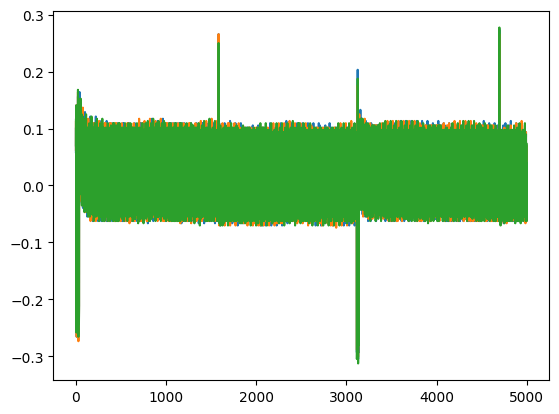

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import chipwhisperer as cw
%matplotlib inline

#Plot traces

print(trace_array)


plt.plot(trace_array[0])

plt.plot(trace_array[1])

plt.plot(trace_array[2])

plt.show()


In [ ]:
#CPA stuff

sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

sboxInv = [
        0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
        0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
        0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
        0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
        0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
        0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
        0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
        0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
        0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
        0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
        0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
        0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
        0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
        0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
        0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
        0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
        ]

def aes_internal(inputdata, key):
    result = key ^ inputdata
    return sbox[result]

def calc_hamming_weight(n):
    return bin(n).count("1")

HW = [0] * 256
for i in range(0, 256):
    HW[i] = calc_hamming_weight(i)

def calc_hamming_weight(n):
    return bin(n).count("1")

HW = [0] * 256
for i in range(0, 256):
    HW[i] = calc_hamming_weight(i)

def mean(X):
    return np.mean(X, axis = 0)
    #raise NotImplementedError("Add your code here, and delete this.")

def std_dev(X, X_bar):
    return np.sqrt((np.sum((X - X_bar) ** 2, axis = 0)))
    #raise NotImplementedError("Add your code here, and delete this.")

def cov(X, X_bar, Y, Y_bar):
    return np.sum((Y - Y_bar) * (X - X_bar), axis = 0)
    #raise NotImplementedError("Add your code here, and delete this.")    

In [ ]:
#Implement the CPA attack
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here

for bnum in tqdm(range(0, 16)):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)    
        cpaoutput = (cov(trace_array, t_bar, hws, hws_bar) / (std_dev(trace_array, t_bar) * std_dev(hws, hws_bar)))
        maxcpa[kguess] = max(abs(cpaoutput))

    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

  0%|          | 0/16 [00:00<?, ?it/s]C:\Users\tcber\AppData\Local\Temp\ipykernel_15172\3236646814.py:12: RuntimeWarning: invalid value encountered in divide
  cpaoutput = (cov(trace_array, t_bar, hws, hws_bar) / (std_dev(trace_array, t_bar) * std_dev(hws, hws_bar)))
100%|██████████| 16/16 [13:35<00:00, 50.99s/it]

Best Key Guess: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
 [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


In [ ]:
from tqdm import tqdm
import numpy as np
import time
import matplotlib as plt

#Attack 2, Cryptanalysis

ktp = cw.ktp.Basic()

trace_array = []
textin_array = []
textout_array = []

def increment_bytearray(text):
    """
    Increment a bytearray as though it represents a large integer in big-endian order.
    """
    carry = 1  # Start with a carry of 1 (incrementing by 1)
    for i in (range(len(text))):  # Start from the last byte
        text[i] += carry
        if text[i] < 256:  # No carry needed; we are done
            carry = 0
            break
        text[i] = 0  # Overflow, set byte to 0 and continue carrying
    
    if carry:  # If carry is still 1, the number overflowed entirely
        print("Warning: Overflow occurred, the bytearray wrapped around to zero.")
    
    return text


#Send key
key = bytearray([2,3,4,4,5,6,7,8,9,10,11,12,13,14,15,16])
while len(key) % 16 != 0:
    key.append(0)
TruncatedKey = key[:16]

target.simpleserial_write('l', TruncatedKey)

N = 10 #100

text = bytearray([0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00])
text = text[0:16]

for i in tqdm(range(0,N), desc='Capturing traces'):

    target.simpleserial_write('e', text)

    response = target.simpleserial_read('r', 16, timeout=500)

    textin_array.append(text)
    textout_array.append(response)
    text[2] = text[2] + 1

    
print(textin_array)
print(textout_array)

for i in range(0,1):
    
    result = [a ^ b for a, b in zip(textout_array[1], textout_array[2])]
    print(result)


Capturing traces: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]

[bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'), bytearray(b'\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')]
[None, CWbytearray(b'4d 2a 11 e0 5e 80 0a c5 59 0e 21 63 c4 a0 74 09'), CWbytearray(b'4d 2a 34 e0 5e 80 0a c5 59 0e 21 63 c4 a0 74 09'), CWbytearray(b'4d 2a 9e e0 5e 80 0a c5 59 0e 21 63 c4 a0 74 09'), CWbytearray(b'4d 

In [32]:
scope.io.clkout = 7.5E6
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

scope
reboot_flush()
scope.arm()
target.simpleserial_write("g", bytearray([]))
scope.capture()
val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']
print(val)
gc = cw.GlitchController(groups=["success", "reset", "normal"], parameters=["repeat", "ext_offset"])
gc.display_stats()

(ChipWhisperer Scope WARNING|File cwnano.py:705) Timeout in cwnano capture()


{'valid': False, 'payload': None, 'full_response': '\x05e\x01\x01¦\x00', 'rv': None}


IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

In [ ]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

#Attack 3, Voltage Glitching

g_step = 1
ct = []

gc.set_global_step(g_step)
gc.set_range("repeat", 10, 15)
gc.set_range("ext_offset", 50, 400)
scope.glitch.repeat = 0

key = bytearray([2,3,4,4,5,6,7,8,9,10,11,12,13,14,15,16])
while len(key) % 16 != 0:
    key.append(0)
TruncatedKey = key[:16]

target.simpleserial_write('l', TruncatedKey)

N = 10 #100

text = bytearray([0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00])
text = text[0:16]

reboot_flush()
sample_size = 1
for glitch_setting in gc.glitch_values():
    scope.glitch.repeat = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[1]
    successes = 0
    resets = 0
    for i in range(3):
        target.flush()
            
        scope.arm()
        
        #Do glitch loop
        target.simpleserial_write("e", text)
        
        ret = scope.capture()
        
        val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10)#For loop check
        
        if ret:
            print('Timeout - no trigger')
            gc.add("reset")
            resets += 1

            #Device is slow to boot?
            reboot_flush()

        else:
            gcnt = struct.unpack("<I", val['payload'][:4])[0]
            #Print out results 
            ct[0:16] = (val['payload'])
            newlst = ct[0:16]
            hex_list = [hex(x) for x in newlst]
            print(hex_list)
            #Increment plaintext to also check if that is different
            text =increment_bytearray(text)
print("Done glitching")

['0x8', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x59', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x55', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x25', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0xb', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x96', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x16', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0x4e', '0xb', '0x98']
['0x5', '0xbd', '0x21', '0x6a', '0xab', '0x22', '0xc7', '0x50', '0x99', '0x3b', '0xc0', '0x81', '0x85', '0

KeyboardInterrupt: 